In [2]:
import sqlite3
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

In [17]:
conn = sqlite3.connect('BerkeleyDB.db')
cur = conn.cursor()

print("Information from Admissions table:\n\nSchema:")
query = """SELECT sql FROM sqlite_master WHERE name='ADMISSIONS';"""
cur.execute(query)
rows = cur.fetchall()
print(rows[0][0])

query = """SELECT count(*) FROM ADMISSIONS;"""
cur.execute(query)
rows = cur.fetchall()
print("\nObseravtions: " + str(rows[0][0]))

Information from Admissions table:

Schema:
CREATE TABLE ADMISSIONS (
  id integer PRIMARY KEY AUTOINCREMENT, 
  name text NOT NULL, 
  gender text NOT NULL, 
  department text NOT NULL, 
  decision integer NOT NULL
)

Obseravtions: 4526


Apparent Bias?


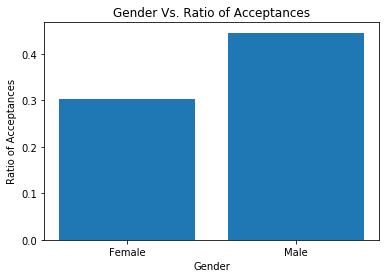

In [28]:
query = """
SELECT gender, avg(decision) 
FROM admissions
GROUP BY gender;"""
cur.execute(query)
rows = cur.fetchall()
rows

gender = []
acceptances = []
for row in rows:
    gender.append(row[0])
    acceptances.append(row[1])
    
genderVsAcceptances = (gender, acceptances)

plt.bar(*genderVsAcceptances);
plt.ylabel('Ratio of Acceptances');
plt.xlabel('Gender');
plt.title("Gender Vs. Ratio of Acceptances");
print("Apparent Bias?")

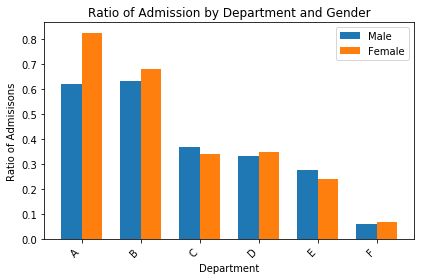

In [40]:
query =  """SELECT gender, department, avg(decision) 
            FROM admissions 
            GROUP BY gender, department;"""
cur.execute(query)
rows = cur.fetchall()

rows

fDept = []
fAdmissions = []
mDept = []
mAdmissions = []
departments = []
for row in rows:
    if row[0]=='Female':
        fAdmissions.append(row[2])
        departments.append(row[1])
    else:
        mAdmissions.append(row[2])

x = np.arange(len(departments)) 
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mAdmissions, width, label='Male')
rects2 = ax.bar(x + width/2, fAdmissions, width, label='Female')

ax.set_ylabel('Ratio of Admisisons')
ax.set_xlabel('Department');
ax.set_title('Ratio of Admission by Department and Gender')
ax.set_xticks(x)
ax.set_xticklabels(departments)
ax.legend()
plt.xticks(rotation=45, ha='right');


fig.tight_layout()
plt.show()

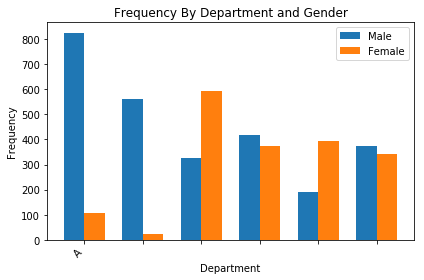

In [44]:
query =  """SELECT gender, department, COUNT(*) 
            FROM admissions 
            GROUP BY gender, department;"""
cur.execute(query)
rows = cur.fetchall()

fN = []
mN = []
for row in rows:
    if row[0]=='Female':
        fN.append(row[2])
    else:
        mN.append(row[2])

x = np.arange(len(departments)) 
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mN, width, label='Male')
rects2 = ax.bar(x + width/2, fN, width, label='Female')

ax.set_ylabel('Frequency')
ax.set_xlabel('Department')
ax.set_title('Frequency By Department and Gender')
ax.set_xticks(x)
ax.set_xticklabels(department)
ax.legend()
plt.xticks(rotation=45, ha='right');

fig.tight_layout()
plt.show()

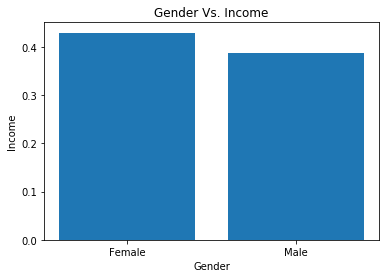

In [57]:
query = """
WITH Blocks AS (
    SELECT gender, department, avg(decision) AS Avge
    FROM admissions
    GROUP BY gender, department),
Weights AS (
    SELECT department, CAST(count(*) AS float)/(SELECT count(*) FROM admissions) AS W
    FROM admissions
    GROUP BY department
    HAVING count(DISTINCT gender)=2)
SELECT gender, sum(Avge*W)
FROM Blocks, Weights
WHERE Blocks.department = Weights.department
GROUP BY gender"""
cur.execute(query)
rows = cur.fetchall()
rows

gender = []
income = []
for row in rows:
    gender.append(row[0])
    income.append(row[1])

genderVsIncome = (gender, income)

plt.bar(*genderVsIncome);
plt.ylabel('Income');
plt.xlabel('Gender');
plt.title("Gender Vs. Income");

In [56]:
query = """
    SELECT department, CAST(count(*) AS float)/(SELECT count(*) FROM admissions) AS W
    FROM admissions
    GROUP BY department
    HAVING count(DISTINCT gender)=2"""
cur.execute(query)
rows = cur.fetchall()
rows

[('A', 0.20614228899690676),
 ('B', 0.12925320371188687),
 ('C', 0.20282810428634557),
 ('D', 0.17498895271763146),
 ('E', 0.12903225806451613),
 ('F', 0.15775519222271323)]

In [13]:
#given distribution by sub-group

dist = {}
dist["men-deptA-admit"] = (825, 62)
dist["men-deptB-admit"] = (560, 63)
dist["men-deptC-admit"] = (325, 37)
dist["men-deptD-admit"] = (417, 33)
dist["men-deptE-admit"] = (191, 28)
dist["men-deptF-admit"] = (373, 6)

dist["women-deptA-admit"] = (108, 82)
dist["women-deptB-admit"] = (25, 68)
dist["women-deptC-admit"] = (593, 34)
dist["women-deptD-admit"] = (375, 35)
dist["women-deptE-admit"] = (393, 24)
dist["women-deptF-admit"] = (341, 7)

totalMen = 0
totalWomen = 0
totalMenAdmitted = 0
totalWomenAdmitted = 0

for sub_group in dist:
  curGroup = sub_group.split("-")
  if curGroup[0] ==  "men":
    totalMen += dist[sub_group][0]
    #multiply admissions number by 0.01 to get percent, and then by # applicants to get total number admitted
    totalMenAdmitted += dist[sub_group][1] * 0.01 * dist[sub_group][0]

  elif curGroup[0] == "women":
    totalWomen  += dist[sub_group][0]
    totalWomenAdmitted += dist[sub_group][1] * 0.01 * dist[sub_group][0]


print("{} men applied and {} men were admitted. {} women applied and {} women were admitted".format(totalMen, round(totalMenAdmitted), totalWomen, round(totalWomenAdmitted)))
print("Overall male admission rate = {maleAdmitP}. Overall female admission rate = {femaleAdmitP}".format(maleAdmitP = round(totalMenAdmitted/totalMen, 2), femaleAdmitP = round(totalWomenAdmitted/totalWomen, 2)))



reformatter = {"men": "man", "women": "woman"} #intended to make certain text nicer


records = []
for sub_group in dist:
   gender, dept, admit_rate = sub_group.split("-")
   dept = dept.replace("dept", "")
   gender = reformatter[gender]
   genderCode = ""
   if gender == "woman" or gender == "women":
     genderCode = "Female"
   elif gender == "man" or gender == "men":
     genderCode = "Male"

   #we only stored admit percent. to get admit number, need to multiply admit percent by 0.01 and by number who applied
   num_applicants, num_admits = dist[sub_group][0], round(dist[sub_group][1] * 0.01 * dist[sub_group][0])

   not_admitted = num_applicants - num_admits
   
   for i in range(num_applicants):
     unique_name = genderCode + str(i) + dept.replace("dept","")

     if i < num_admits:
        records.append([unique_name, genderCode, dept, 1]) #Y stands for admitted.
     else:
       records.append([unique_name, genderCode, dept, 0])


import random

random.seed(10)
random.shuffle(records)

#print out records or save to csv
for i in range(10):
  print(records[i])

2691 men applied and 1198 men were admitted. 1835 women applied and 557 women were admitted
Overall male admission rate = 0.45. Overall female admission rate = 0.3
['Male46A', 'Male', 'A', 1]
['Male364B', 'Male', 'B', 0]
['Male158A', 'Male', 'A', 1]
['Male453B', 'Male', 'B', 0]
['Female248C', 'Female', 'C', 0]
['Male399A', 'Male', 'A', 1]
['Male771A', 'Male', 'A', 0]
['Female97E', 'Female', 'E', 0]
['Male53D', 'Male', 'D', 1]
['Male705A', 'Male', 'A', 0]


In [16]:
import sqlite3


make_table_statement = """CREATE TABLE IF NOT EXISTS ADMISSIONS (
  id integer PRIMARY KEY AUTOINCREMENT, 
  name text NOT NULL, 
  gender text NOT NULL, 
  department text NOT NULL, 
  decision integer NOT NULL
);"""

try:
    sqliteConnection = sqlite3.connect('SQLite_Python.db')
    cursor = sqliteConnection.cursor()

    cursor.execute("DROP TABLE IF EXISTS ADMISSIONS") #clear the table and make fresh
    cursor.execute(make_table_statement)
    
    print("Database created and Successfully Connected to SQLite")
    sqliteConnection.commit()


    for record in records:
      name, gender, department, decision = record[0], record[1], record[2], record[3]
    
    
      
      cursor.execute("INSERT INTO ADMISSIONS(name, gender, department, decision) VALUES(?,?,?,?)", (name, gender, department, decision))
    
    sqliteConnection.commit()
    cursor.close()
    print("Done saving")
except:
    print("DB operation failed")
    pass

Database created and Successfully Connected to SQLite
Done saving
